# **CLASE 7: Evaluación avanzada (Curva ROC y Métricas de Coste).**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
ruta_archivo = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(ruta_archivo)

# **Preprocesamiento**

In [3]:
X = df[['MonthlyCharges','TotalCharges']]
y = df['Churn']
# Convertimos a numérico forzando errores a NaN (por si hay espacios en blanco)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X['TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].mean())
# Convertimos a binaria
y = df['Churn'].map({'Yes': 1, 'No': 0})
# 5. DIVISIÓN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **ENTRENAMIENTO DEL "BOSQUE"**
Creamos un bosque de 100 árboles

In [4]:
modelo_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=5,
                                       random_state=42)
modelo_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

## **OBTENER PREDICCIONES Y PROBABILIDADES**
No queremos solo 0 o 1, queremos la probabilidad (0.0 a 1.0)

In [5]:
preds = modelo_forest.predict(X_test)
probs = modelo_forest.predict_proba(X_test)[:, 1]
X_test['preds'] = preds
X_test['probs'] = probs
X_test['y_test'] = y_test
X_test.head()

,MonthlyCharges,TotalCharges,preds,probs,y_test
185,24.80,24.80,0,0.472013,1
2715,25.25,996.45,0,0.063231,0
3825,19.35,1031.70,0,0.042193,0
1807,76.35,76.35,1,0.806905,1
132,50.55,3260.10,0,0.114274,0


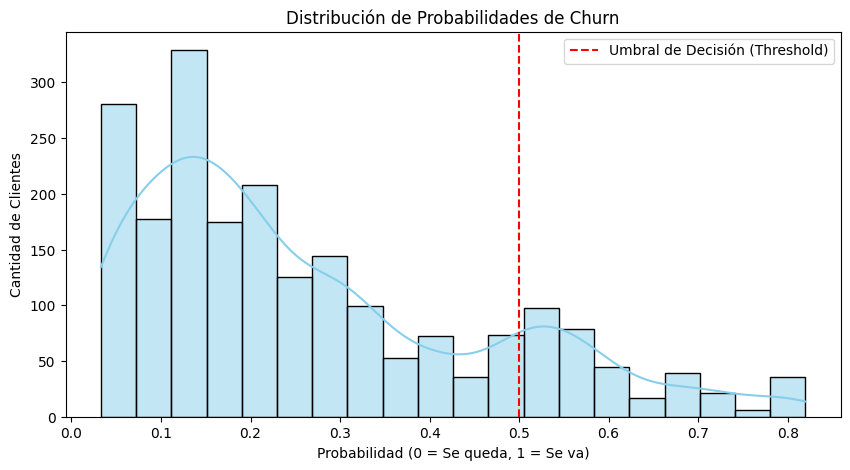

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(probs, bins=20, kde=True, color="skyblue")
plt.axvline(x=0.5, color='red', linestyle='--', label='Umbral de Decisión (Threshold)')
plt.title('Distribución de Probabilidades de Churn')
plt.xlabel('Probabilidad (0 = Se queda, 1 = Se va)')
plt.ylabel('Cantidad de Clientes')
plt.legend()
plt.show()

**Interpretación:** Si ves muchas barras cerca de 0 y cerca de 1, tu modelo está muy seguro. Si ves muchas barras cerca de 0.5, tu modelo está "confundido" y tiene poca potencia de inferencia.

## **CALCULAR Y VISUALIZAR LA CURVA ROC**

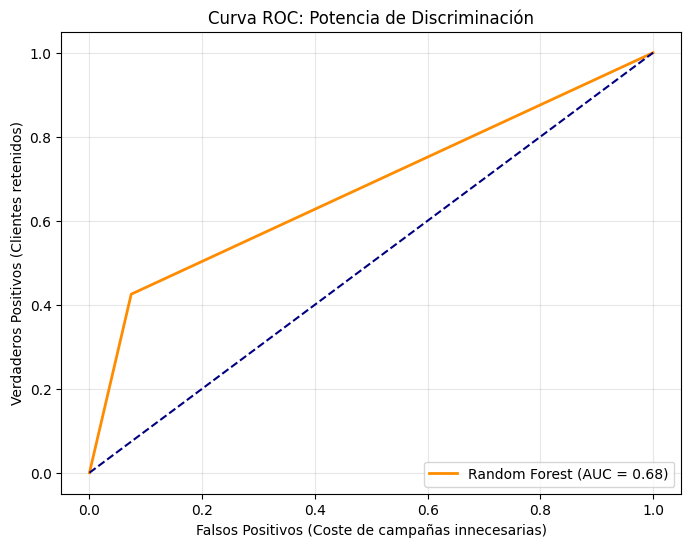

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc_score = roc_auc_score(y_test, preds)

# 3. VISUALIZACIÓN DE LA CURVA ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Línea de azar
plt.xlabel('Falsos Positivos (Coste de campañas innecesarias)')
plt.ylabel('Verdaderos Positivos (Clientes retenidos)')
plt.title('Curva ROC: Potencia de Discriminación')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

**La Curva ROC: El "Mando de Control" del Riesgo**
La Curva ROC es un gráfico que nos dice qué tan bueno es nuestro modelo separando "lo bueno de lo malo" sin importar si somos estrictos o no.

El eje Y (True Positive Rate): Es el Recall. Representa cuántos clientes detectamos que verdaderamente retenemos. Queremos que esté lo más alto posible.

El eje X (False Positive Rate): Representa cuántos clientes damos por posible de retener cuando en ralidad no es así, por tanto se desperdician recursos. Queremos que esté lo más a la izquierda posible.

¿Cómo leerla rápido?
La diagonal (línea de puntos): Es el azar. Si tu curva está ahí, el modelo es tan útil como lanzar una moneda al aire.

La curva hacia la esquina superior izquierda: Cuanto más se "infle" la curva hacia arriba a la izquierda, mejor es el modelo. Significa que puedes detectar muchos casos (Y alto) sin desperdiciar recursos innecesariamente (X bajo).

## **EL IMPACTO DEL UMBRAL (THRESHOLD)**
🧠 **Probabilidad vs. Decisión: El papel del Analista**

El modelo de Machine Learning no dice "Este cliente se va". Lo que dice es: "Tengo un 72% de sospecha de que este cliente se va".

La Probabilidad: Es el valor bruto (ej. 0.72). Es la medida de incertidumbre del algoritmo.

El Umbral (Threshold): Por defecto es 0.5. Es la línea que dibujamos nosotros.

La Predicción: Es la etiqueta final. Si la probabilidad (0.72) es mayor que el umbral (0.5), el modelo predice "1" (Fuga).
¿Qué pasa si solo actuamos si la probabilidad es > 0.7?

In [9]:
print(f"--- ANÁLISIS CON UMBRAL POR DEFECTO (0.5) ---")
print(classification_report(y_test, preds))

--- ANÁLISIS CON UMBRAL POR DEFECTO (0.5) ---
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1539
           1       0.68      0.43      0.52       574

    accuracy                           0.79      2113
   macro avg       0.75      0.68      0.69      2113
weighted avg       0.78      0.79      0.77      2113



In [10]:
umbral = 0.7
pred_ajustada = (probs > umbral).astype(int)

print(f"--- ANÁLISIS CON UMBRAL {umbral} ---")
print(classification_report(y_test, pred_ajustada))

--- ANÁLISIS CON UMBRAL 0.7 ---
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1539
           1       0.85      0.10      0.17       574

    accuracy                           0.75      2113
   macro avg       0.80      0.54      0.51      2113
weighted avg       0.77      0.75      0.67      2113



## **ANÁLISIS DEL BALANCEO DE CLASES**

In [11]:
distribucion_clases = df['Churn'].value_counts(normalize=True) * 100
print(f"\nDistribución global de clases:")
print(f"• No Churn: {distribucion_clases.get('No', 0):.1f}% ({df['Churn'].value_counts().get('No', 0):,} clientes)")
print(f"• Churn: {distribucion_clases.get('Yes', 0):.1f}% ({df['Churn'].value_counts().get('Yes', 0):,} clientes)")


Distribución global de clases:
• No Churn: 73.5% (5,174 clientes)
• Churn: 26.5% (1,869 clientes)


## **CURVA PRECISION-RECALL PARA CLASES DESBALANCEADAS**

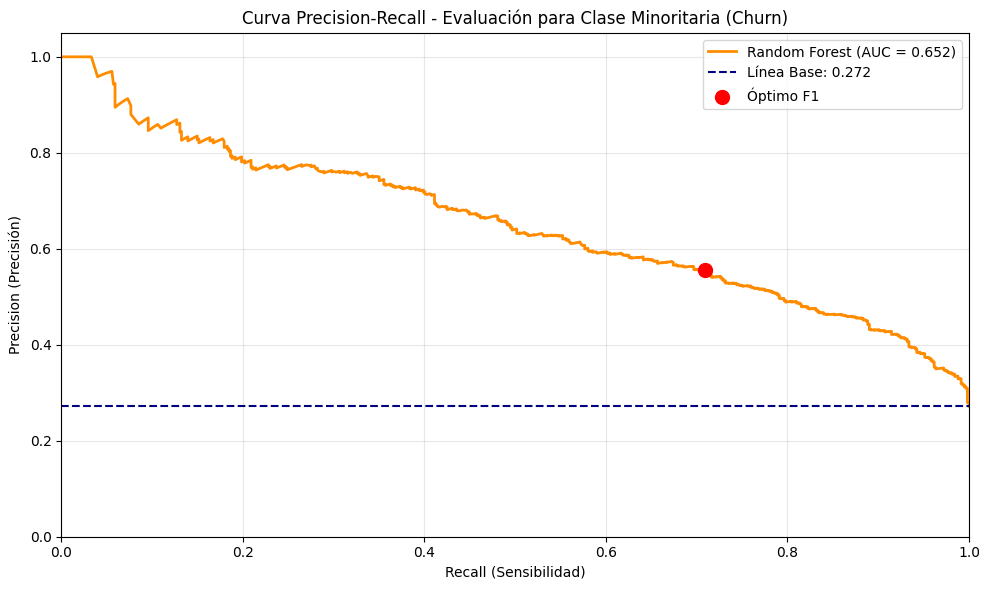

In [12]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
precision, recall, thresholds_pr = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

# Valor de referencia (modelo random)
precision_baseline = (y_test == 1).mean()

# Gráfico Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2,
         label=f'Random Forest (AUC = {pr_auc:.3f})')
plt.axhline(y=precision_baseline, color='navy', linestyle='--',
            label=f'Línea Base: {precision_baseline:.3f}')

# Encontrar punto óptimo (mayor F1-Score)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

plt.scatter(recall[optimal_idx], precision[optimal_idx],
            color='red', s=100, zorder=5,
            label='Óptimo F1')

plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision (Precisión)')
plt.title('Curva Precision-Recall - Evaluación para Clase Minoritaria (Churn)')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

 **LA LÍNEA BASE (Baseline) - El "Piso Mínimo"**
 Representa el desempeño de un modelo que ADIVINA AL AZAR

💼 INTERPRETACIÓN EN EL NEGOCIO:
"Si eligiéramos clientes al azar para retener, acertaríamos el 27% de las veces.
Cualquier punto por ENCIMA de esta línea significa que nuestro modelo es MEJOR que adivinar.
Cualquier punto por DEBAJO significa que es PEOR que adivinar (¡catastrófico!)."

**THRESHOLD ÓPTIMO - El "Punto Dulce" de Rentabilidad**

- El punto rojo en la curva donde el F1-Score es máximo
- Representa el mejor balance entre no molestar clientes innecesariamente y no perder clientes valiosos